# Bag of Visual Words

## Importing the Libraries



In [1]:
import numpy as np
import cv2 
import torch
import torchvision
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

In [2]:
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix

In [5]:
def show_results(clf, X, y, imgs, show_positive=True):
  preds = clf.predict(X)
  idxs = np.where((preds == y) == show_positive)[0]

  fig = plt.figure(figsize=(20, 10))

  show_idx = []
  for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(idxs.shape[0])
    while idx in show_idx:
      idx = np.random.randint(idxs.shape[0])
    show_idx.append(idx)
    val = idxs[idx]
    plt.title(f"Pred={preds[val]}, Label={y[val]}")
    plt.axis('off')
    plt.imshow(imgs[val])

  plt.show()

## Loading the Dataset

In [6]:
transform_img = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150, 150)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.permute(2, 1, 0).permute(1, 0, 2) * 255)
])
dataset =  torchvision.datasets.ImageFolder(root='../dataset/SUN_data/train/', transform=transform_img)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=True)

In [7]:
img_arr, label_arr = next(iter(train_dataloader))
img_arr = img_arr.numpy().astype(np.uint8)
label_arr = label_arr.numpy()

0


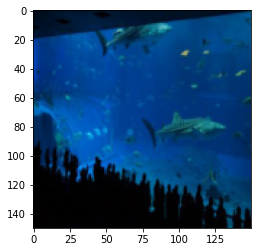

In [8]:
plt.imshow(img_arr[100])
print(label_arr[100])

In [9]:
img_arr_gray = np.zeros(img_arr.shape[:-1], dtype=np.uint8)

In [10]:
for i in range(img_arr.shape[0]):
    img_arr_gray[i] = cv2.cvtColor(img_arr[i], cv2.COLOR_RGB2GRAY)

0


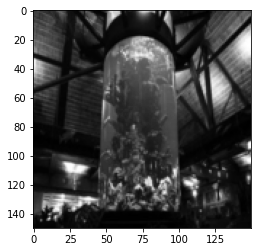

In [11]:
plt.imshow(img_arr_gray[0], cmap='gray')
print(label_arr[0])

## Performing Dense SIFT

In [12]:
step_size = 10
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, 150, step_size) 
                                    for x in range(0, 150, step_size)]

desc_arr = np.zeros((img_arr.shape[0], len(kp), 128))

sift = cv2.SIFT_create()
for i in tqdm.tqdm(range(img_arr.shape[0])):
    
    _, desc = sift.compute(img_arr_gray[i], kp)
    
    desc_arr[i] = desc

In [13]:
desc_arr.shape

(640, 225, 128)

In [14]:
reshaped_desc = desc_arr.reshape(-1, 128)
reshaped_desc.shape

(144000, 128)

## Training KMeans

In [15]:
N_CLUSTERS = 500
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=3).fit(reshaped_desc)

In [16]:
kmeans_labels = kmeans.labels_.reshape(desc_arr.shape[:-1])

## Training

### Preparing Normalized Histograms

In [17]:
freq_table = np.zeros((img_arr.shape[0], N_CLUSTERS))
freq_table.shape

(640, 500)

In [18]:
for i in range(N_CLUSTERS):
    freq_table[:, i] = np.sum(kmeans_labels == i, axis=1)

### Preparing TF-IDF

In [19]:
tf = np.log(freq_table + 1)

In [20]:
tf_Doc = np.zeros(N_CLUSTERS)
for i in range(N_CLUSTERS):
  tf_Doc[i] = np.sum(np.sum(kmeans_labels == i, axis=1) != 0)

idf = np.log(img_arr.shape[0]/(1 + tf_Doc))

In [21]:
tfidf = tf * idf

In [22]:
freq_table = freq_table/kmeans_labels.shape[-1]

### Training using LinearSVC with One vs Rest Multiclass Setting

In [23]:
clf = LinearSVC(max_iter=10000, C=10).fit(freq_table, label_arr)
tfidf_clf = LinearSVC(max_iter=20000, C=0.001).fit(tfidf, label_arr)

### Training Results

In [24]:
print(f"Normalized Histogram - Training Accuracy: {np.mean(clf.predict(freq_table) == label_arr)}")
print(f"TFIDF - Training Accuracy: {np.mean(tfidf_clf.predict(tfidf) == label_arr)}")

Normalized Histogram - Training Accuracy: 0.9328125
TFIDF - Training Accuracy: 0.96875


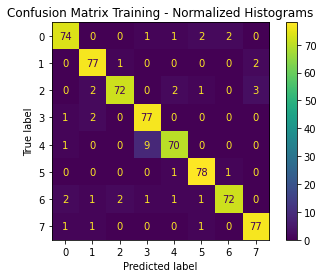

In [25]:
plot_confusion_matrix(clf, freq_table, label_arr)
plt.title("Confusion Matrix Training - Normalized Histograms")
plt.show()

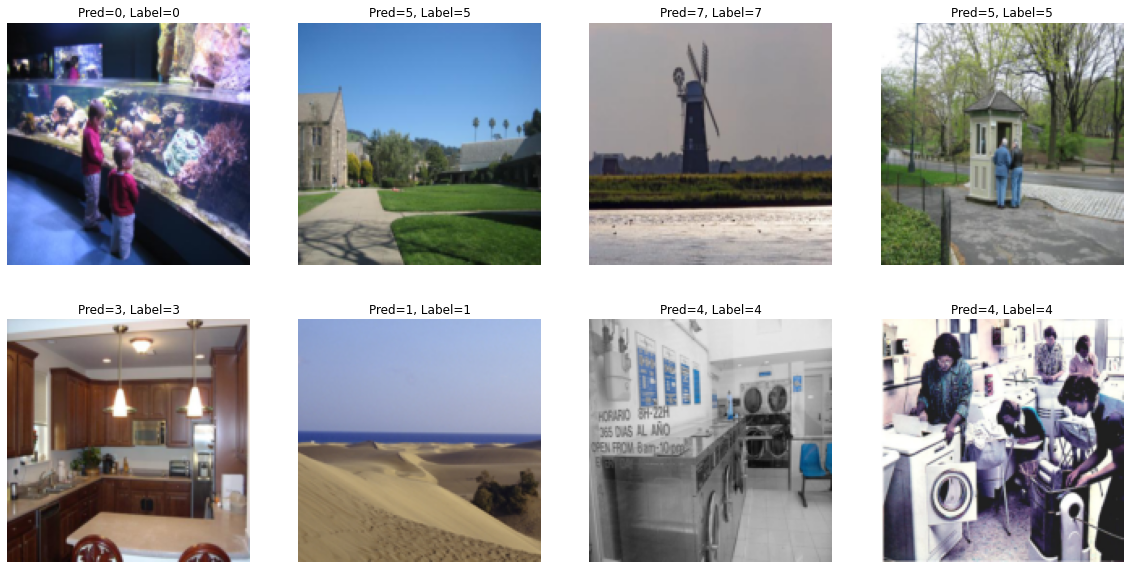

In [26]:
show_results(clf, freq_table, label_arr, img_arr, show_positive=True)

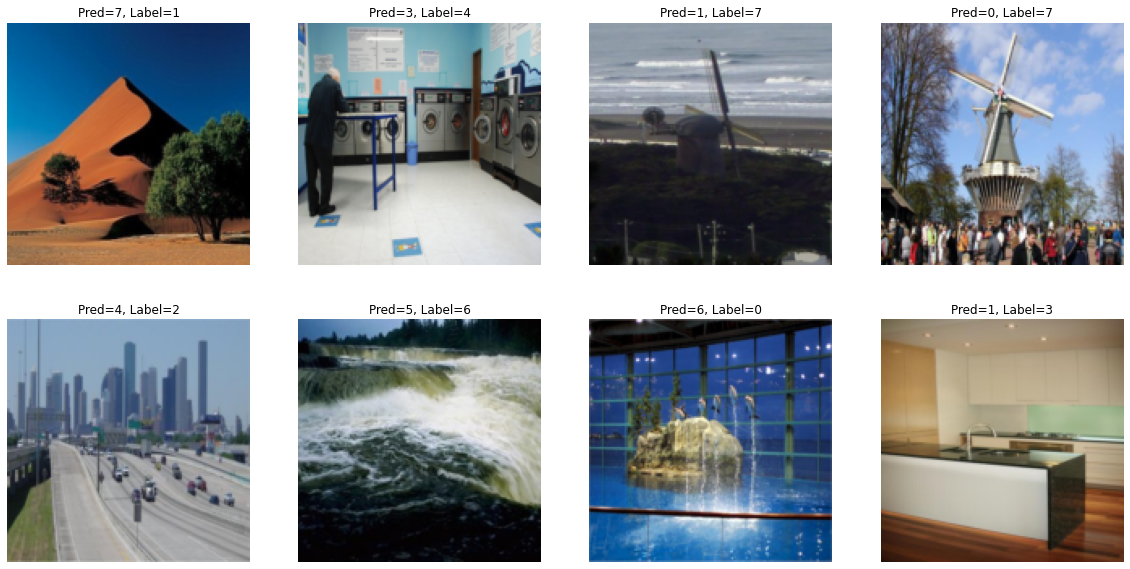

In [27]:
show_results(clf, freq_table, label_arr, img_arr, show_positive=False)

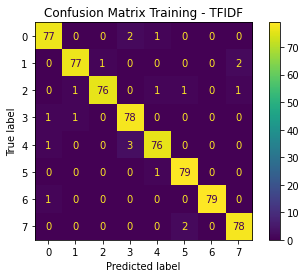

In [28]:
plot_confusion_matrix(tfidf_clf, tfidf, label_arr)
plt.title("Confusion Matrix Training - TFIDF")
plt.show()

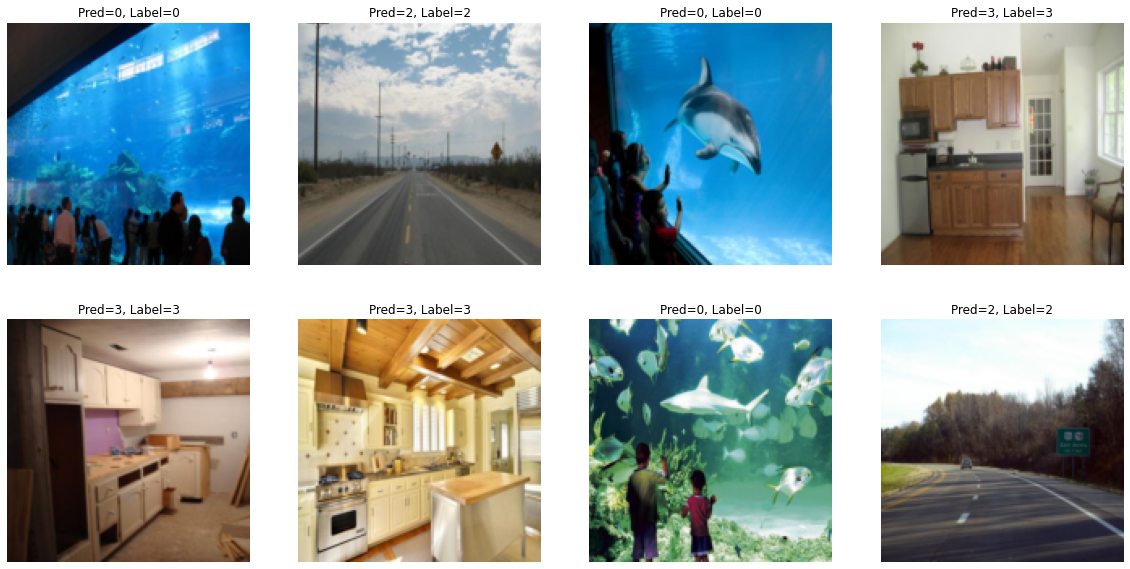

In [29]:
show_results(tfidf_clf, tfidf, label_arr, img_arr, show_positive=True)

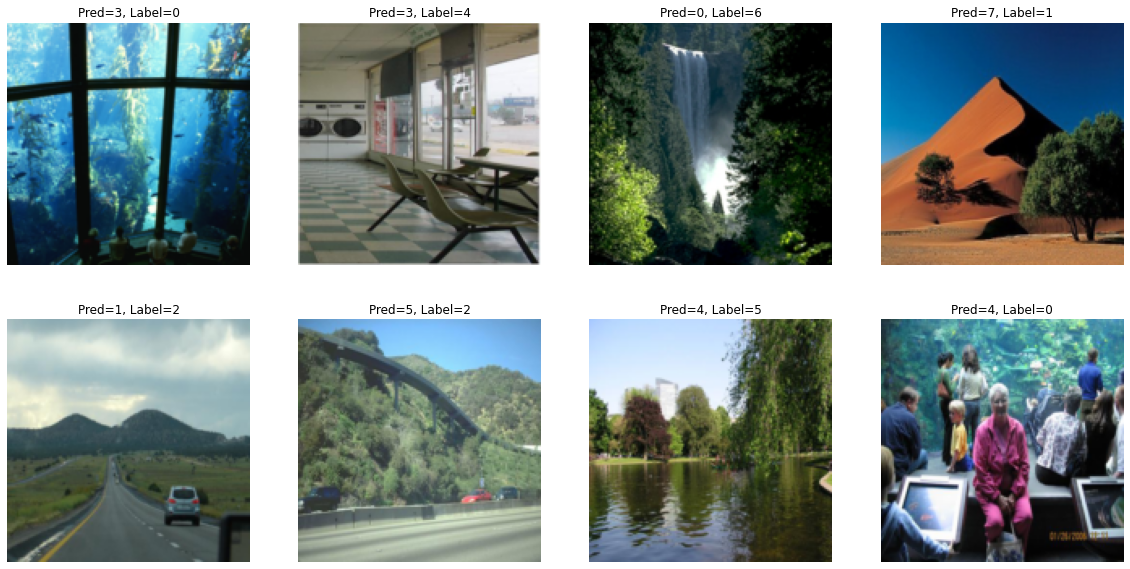

In [30]:
show_results(tfidf_clf, tfidf, label_arr, img_arr, show_positive=False)

We can see that there is a slight decrease in the performance of TF-IDF compared to the normalized histograms. This is kind of expected as for TF-IDF parameter tuning can be extremely crucial. 

TF-IDF is supposed to improve the convergence of the algorithm by providing a better Condition Number. There is generally not a huge improvement in performance because in this setting there are typically few noisy directions that are prunable in this way. On the other hand, the final performance is more dependent on the parameter tuning for `LinearSVC`.

## Test Dataset

### Loading the Dataset

In [31]:
transform_img = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150, 150)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.permute(2, 1, 0).permute(1, 0, 2) * 255)
])
test_dataset =  torchvision.datasets.ImageFolder(root='../dataset/SUN_data/test/', transform=transform_img)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

In [32]:
test_img_arr = next(iter(test_dataloader))[0].numpy().astype(np.uint8)
test_label_arr = next(iter(test_dataloader))[1].numpy()

In [33]:
test_img_arr_gray = np.zeros(test_img_arr.shape[:-1], dtype=np.uint8)
for i in range(test_img_arr.shape[0]):
    test_img_arr_gray[i] = cv2.cvtColor(test_img_arr[i], cv2.COLOR_RGB2GRAY)

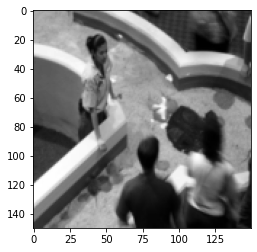

In [34]:
plt.imshow(test_img_arr_gray[0], cmap='gray')

### Performing Dense SIFT

In [35]:
step_size = 10
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, 150, step_size) 
                                    for x in range(0, 150, step_size)]

desc_arr = np.zeros((test_img_arr.shape[0], len(kp), 128))

sift = cv2.SIFT_create()
for i in tqdm.tqdm(range(test_img_arr.shape[0])):
    
    _, desc = sift.compute(test_img_arr_gray[i], kp)
    
    desc_arr[i] = desc

### Assigning KMeans Labels

In [36]:
kmeans_labels_test = kmeans.predict(desc_arr.reshape(-1, 128)).reshape(desc_arr.shape[:-1])
kmeans_labels_test.shape

(160, 225)

### Preparing Normalized Histograms

In [37]:
test_freq_table = np.zeros((test_img_arr.shape[0], N_CLUSTERS))
test_freq_table.shape

(160, 500)

In [38]:
for i in range(N_CLUSTERS):
    test_freq_table[:, i] = np.sum(kmeans_labels_test == i, axis=1)

### Preparing TF-IDF

In [39]:
test_tf = np.log(test_freq_table + 1)

test_tf_Doc = np.zeros(N_CLUSTERS)
for i in range(N_CLUSTERS):
  test_tf_Doc[i] = np.sum(np.sum(kmeans_labels_test == i, axis=1) != 0)


test_idf = np.log(test_img_arr.shape[0]/(1 + test_tf_Doc))

In [40]:
test_tfidf = test_tf * test_idf
test_freq_table = test_freq_table/kmeans_labels_test.shape[-1]

### Test Dataset Results

In [41]:
print(f"Normalized Histogram - Test Accuracy: {np.mean(clf.predict(test_freq_table) == test_label_arr)}")
print(f"TFIDF - Test Accuracy: {np.mean(tfidf_clf.predict(test_tfidf) == test_label_arr)}")

Normalized Histogram - Test Accuracy: 0.68125
TFIDF - Test Accuracy: 0.70625


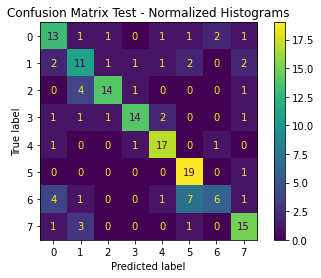

In [42]:
plot_confusion_matrix(clf, test_freq_table, test_label_arr)
plt.title("Confusion Matrix Test - Normalized Histograms")
plt.show()

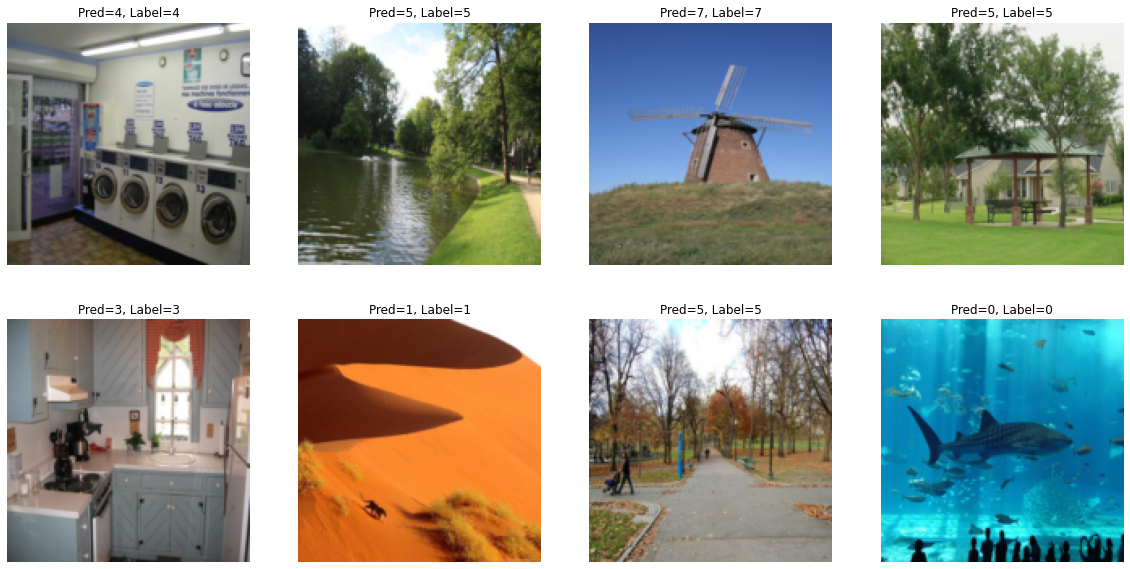

In [43]:
show_results(clf, test_freq_table, test_label_arr, test_img_arr, show_positive=True)

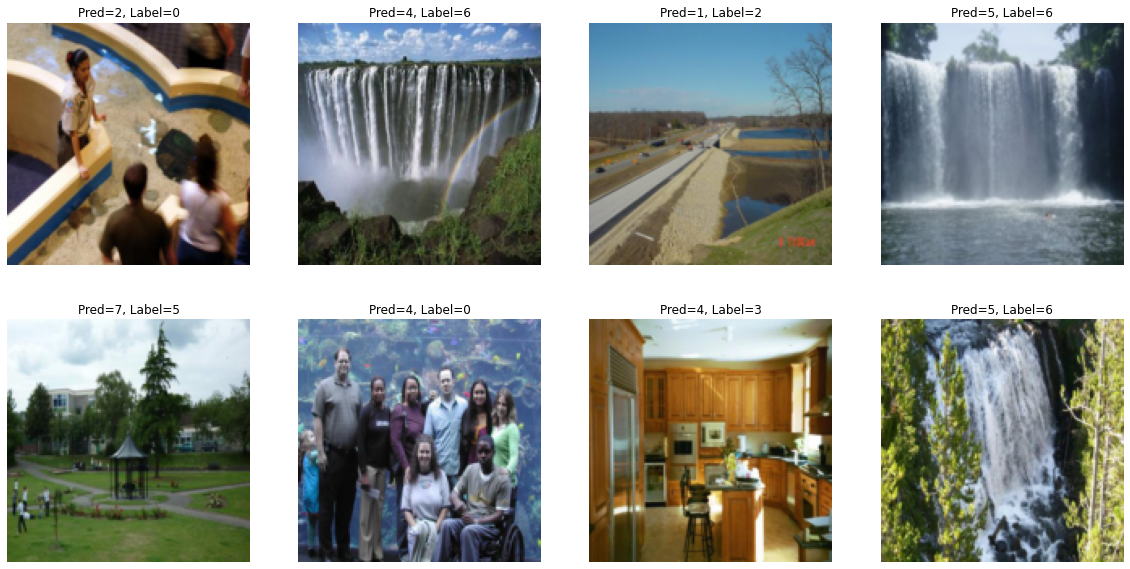

In [44]:
show_results(clf, test_freq_table, test_label_arr, test_img_arr, show_positive=False)

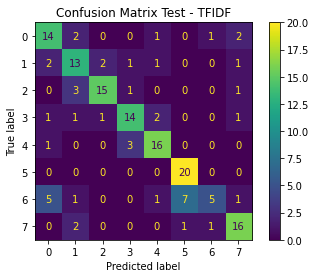

In [45]:
plot_confusion_matrix(tfidf_clf, test_tfidf, test_label_arr)
plt.title("Confusion Matrix Test - TFIDF")
plt.show()

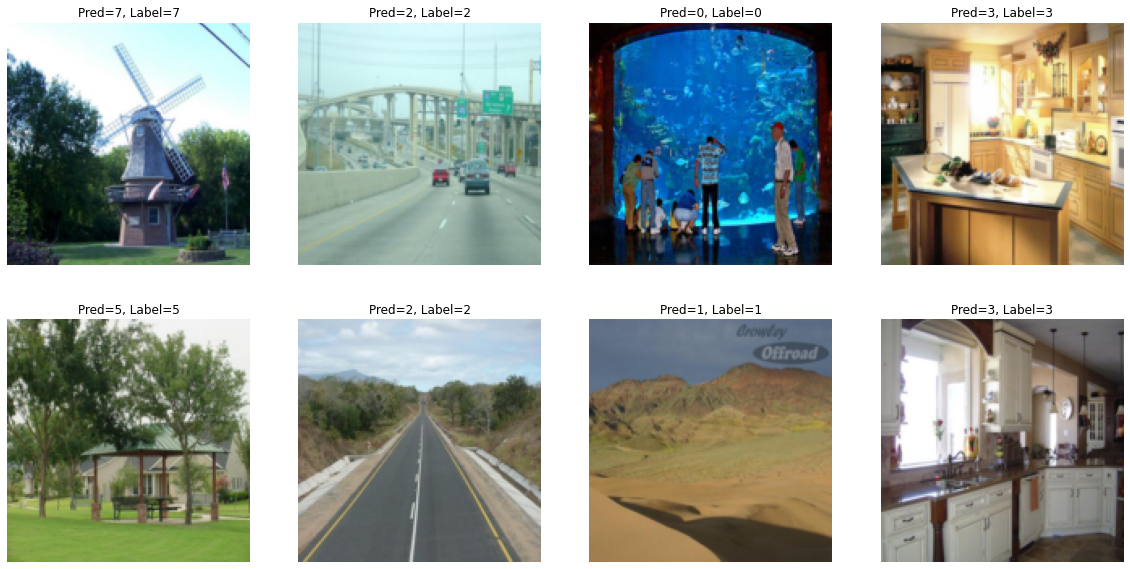

In [46]:
show_results(tfidf_clf, test_tfidf, test_label_arr, test_img_arr, show_positive=True)

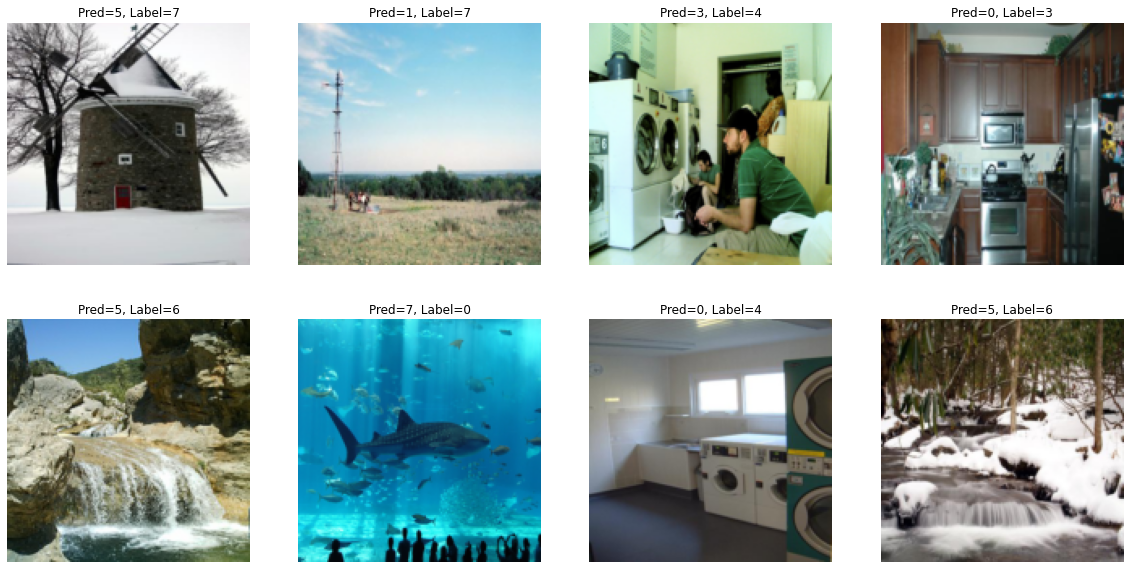

In [47]:
show_results(tfidf_clf, test_tfidf, test_label_arr, test_img_arr, show_positive=False)